In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact, FloatSlider, IntSlider, Button, Output 
display(HTML("<style>.rendered_html.text_cell_render {max-width:600px; }</style>")) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SLAM Benchmarking datasets

Lidar scans from different environments, including MIT CSAIL and MIT Killian Court:
- http://ais.informatik.uni-freiburg.de/slamevaluation/datasets.php
    - Some info about the file format can be found [here](http://ais.informatik.uni-freiburg.de/slamevaluation/software.php).
    - Example: `FLASER`, `num_readings`, `range_readings...`, `x`, `y`, `theta`, `odom_x`, `odom_y`, `odom_theta`, `timestamp`, `hostname`, `logger_timestamp`.

Other resources
- https://sites.google.com/view/awesome-slam-datasets/
- https://github.com/youngguncho/awesome-slam-datasets

In [3]:
from nbx.fileio import load, dump
from nbx.utils import listmap
import matplotlib.pyplot as plt
import numpy as np

# MIT CSAIL

In [15]:
fname = "data/mit-csail.clf"
data  = load(fname, format=".txt")

# ----------
print(len(data))
# Print first 75 characters only ...
for line in data[:6]: print(f"`{line:<.75s}...`")

1991
`# message formats defined: PARAM SYNC ODOM RAWLASER1 RAWLASER2 RAWLASER3 RA...`
`# (old) # FLASER num_readings [range_readings] x y theta odom_x odom_y odom...`
`# (old) # REMISSIONFLASER num_readings [range_readings remission_value]...`
`FLASER 361 1.40 1.39 1.39 1.39 1.38 1.36 1.37 1.36 1.35 1.34 1.34 1.33 1.33...`
`FLASER 361 1.40 1.40 1.39 1.39 1.37 1.37 1.36 1.36 1.35 1.34 1.34 1.33 1.33...`
`FLASER 361 1.40 1.40 1.39 1.39 1.37 1.36 1.37 1.36 1.35 1.34 1.33 1.33 1.33...`


In [16]:
z   = []
x   = []
hd  = []
dx  = []
dhd = []

# Extract range readings and 
# motion control data
for line in data[3:-1]:
    v = line.split(" ")
    num = int(v[1]) # num_readings
    v = v[2:]
    
    z.append(  listmap(float, v[:num]))
    x.append(  listmap(float, v[num:num+2]))
    hd.append( listmap(float, v[num+2:num+3]))
    dx.append( listmap(float, v[num+3:num+5]))
    dhd.append(listmap(float, v[num+5:num+6]))
    
z   = np.array(z)
x   = np.array(x)
hd  = np.array(hd)
dx  = np.array(dx)
dhd = np.array(dhd)

z.shape, x.shape, hd.shape, dx.shape, dhd.shape

((1987, 361), (1987, 2), (1987, 1), (1987, 2), (1987, 1))

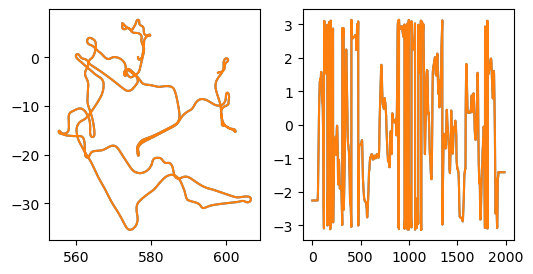

In [12]:
# Rem: turns out `x == dx` and `hd == dhd`...
# Thus we have to recompute dx and dhd
fig, axs = plt.subplots(1,2,figsize=(6,3))
axs[0].plot(x[:,0], x[:,1])
axs[0].plot(dx[:,0], dx[:,1])
axs[1].plot(hd[:,0])
axs[1].plot(dhd[:,0])

In [78]:
# Setting controls
# `dx` and `dhd`
hd  = hd[:,0]
dx  = x[1:,:] - x[:-1,:]
dhd = hd[1:] - hd[:-1]

dx.shape, dhd.shape

((1987, 2), (1987,))

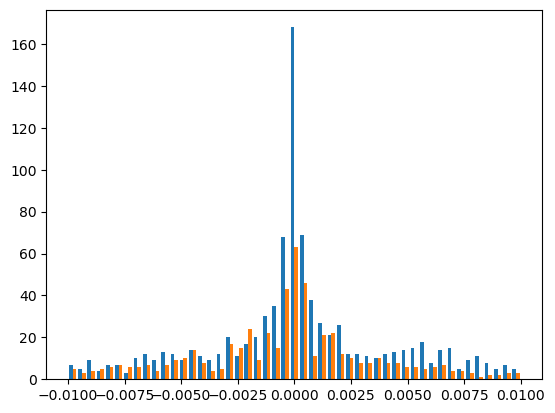

In [88]:
da0 = hd[ :-1] - np.arctan2(dx[:,1], dx[:,0])
da1 = hd[1:  ] - np.arctan2(dx[:,1], dx[:,0])

plt.hist([da0, da1], bins=np.linspace(-0.01,0.01,50));

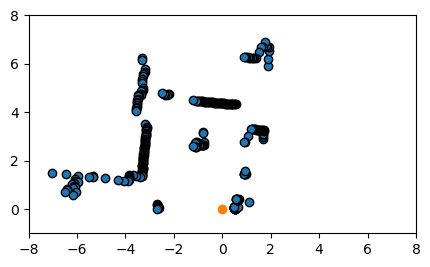

In [80]:
# FOV is actually 180 degrees not 360 degrees!
a = np.arange(361)/360*(np.pi)

t = np.random.randint(len(z))
# ------------------------
plt.figure(figsize=(5,5))
plt.xlim(-8,8)
plt.ylim(-1,8)
plt.gca().set_aspect(1.0)
plt.scatter(z[t]*np.cos(a),z[t]*np.sin(a), edgecolor="k");
plt.scatter(0,0);

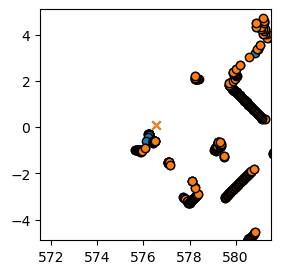

In [85]:
# Check if poses are estimates or groundtruth
# (they are not)
t  = np.random.randint(len(z))
t_ = t+5
# ------------------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1.0)
plt.xlim(x[t,0]-5,x[t,0]+5)
plt.ylim(x[t,1]-5,x[t,1]+5)
# 
plt.scatter(z[t]*np.cos(a + hd[t]) + x[t,0],z[t]*np.sin(a + hd[t]) + x[t,1], edgecolor="k");
plt.scatter(*x[t], c="C0", marker="x");
# 
plt.scatter(z[t_]*np.cos(a + hd[t_]) + x[t_,0],z[t_]*np.sin(a + hd[t_]) + x[t_,1], edgecolor="k");
plt.scatter(*x[t_], c="C1", marker="x");

In [25]:
dx.shape, hd.shape

((1987, 2), (1988, 1))

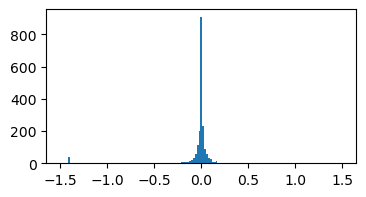

In [9]:
plt.figure(figsize=(4,2))
plt.hist(hd[:-1,0] - np.arctan2(dx[:,1],dx[:,0]), bins=np.linspace(-1.5,1.5,num=150));

## Animation

In [27]:
from ipywidgets import interact, FloatSlider, IntSlider

@interact(
    t = IntSlider( min=0, max=len(z)-1, step=2, value=1050, description='t:'),
)
def func(t):
    a = np.arange(361)/360*(np.pi)

    plt.figure(figsize=(5,5))
    plt.xlim(-12,12)
    plt.ylim(-1,18)
    plt.gca().set_aspect(1.0)
    plt.scatter(z[t]*np.cos(a),z[t]*np.sin(a), edgecolor="k");
    plt.scatter(0,0);


interactive(children=(IntSlider(value=1050, description='t:', max=1987, step=2), Output()), _dom_classes=('wid…

## Save data

In [30]:
z.shape, a.shape, x.shape, hd.shape, dhd.shape, dx.shape

((1988, 361), (361,), (1988, 2), (1988, 1), (1987,), (1987, 2))

In [29]:
dump(dict(
    z   = z.tolist(), 
    a   = (a - np.pi/2).tolist()
    x   = x.tolist(),
    hd  = hd[:,0].tolist(), 
    dx  = dx.tolist(), 
    dhd = dhd.tolist(), 

), "data/mit-csail.json");